In [1]:
!pip install diffusers transformers

In [2]:
!pip install -q datasets diffusers transformers accelerate torchmetrics[image]

In [3]:
! pip install accelerate

In [4]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device

## Stable Diffusion model from CompVis - genration of medical images

In [8]:
model_id = 'CompVis/stable-diffusion-v1-4'

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompts = ["Chest X-ray of healthy lungs",
           "MRI axial slice of a healthy brain",
           "Computed tomography slice knee",
           "Ultrasound of baby in 21st week of pregnancy",]

images_general = pipe(prompts, num_images_per_prompt=1, output_type="numpy").images

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
columns = len(prompts)

fig, axs = plt.subplots(1, columns, figsize=(30,6))
axs = axs.flatten()
for i in range(columns):
    axs[i].imshow(images_general[i, :, :, :])
    axs[i].axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [10]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path='openai/clip-vit-base-patch16')


def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)


sd_clip_score = calculate_clip_score(images_general, prompts)
print(f"CLIP score: {sd_clip_score}")


CLIP score: 29.2922


## Stable Diffusion model fine-tuned on ROCO Medical Dataset

In [12]:
model_id = "Nihirc/Prompt2MedImage"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

images_medical = pipe(prompts, num_images_per_prompt=1, output_type="numpy").images

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

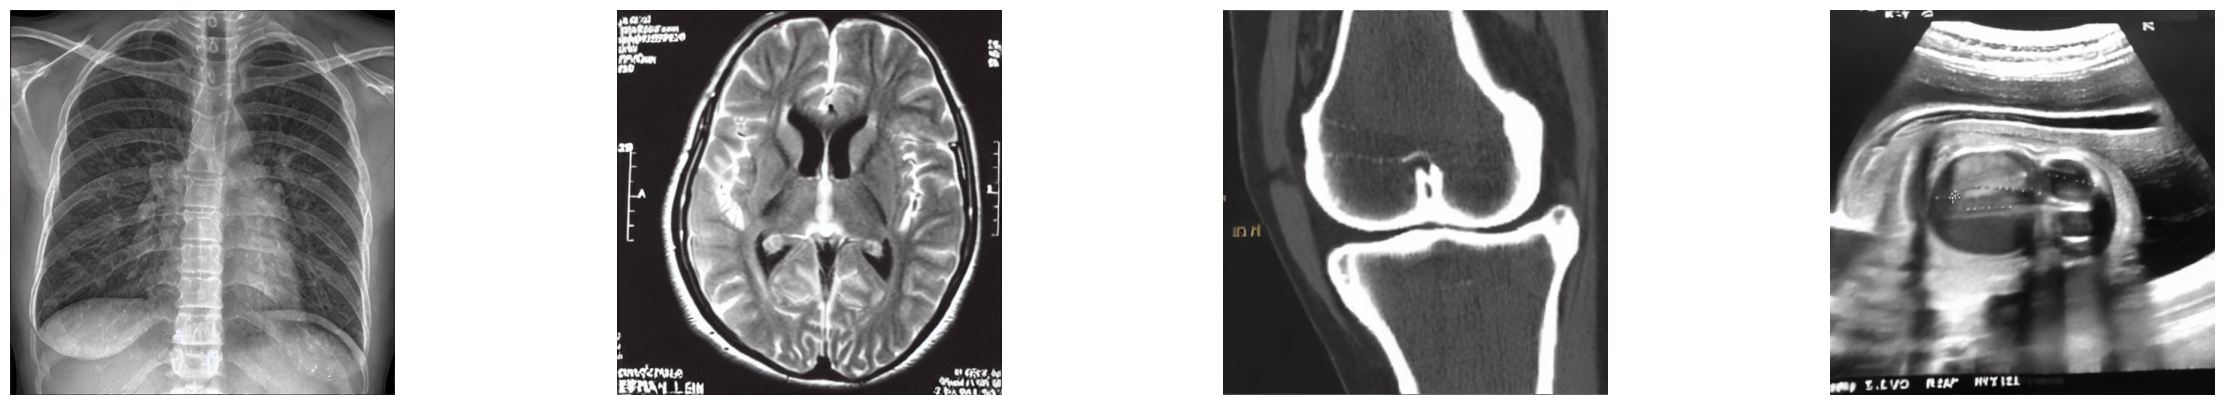

In [13]:
fig, axs = plt.subplots(1, columns, figsize=(30,5))
axs = axs.flatten()
for i in range(columns):
    axs[i].imshow(images_medical[i, :, :, :])
    axs[i].axis('off')

In [14]:
sd_clip_score = calculate_clip_score(images_medical, prompts)
print(f"CLIP score: {sd_clip_score}")

CLIP score: 31.5092
